# **Three main ideas are behind the SVM:**

1. **Maximum margin separator:** draw the line or hyperplane that maximizes the distance between the separator and the training data, thus introducing a margin slab

2. **Soft margin separator:** when data with different labels is mixed up, draw the best separator line taking into account for the samples within the margin slab

3. **Kernel trick:** for more complex models in which the data separation boundary is not linear, allow for higher-order polynomials or even not polynomial functions

#How does it find this hyperplane? 
  By finding the optimal values w* (weights/normal) and b* (intercept) which define this hyperplane. The optimal values are found by minimizing a cost function. Once the algorithm identifies these optimal values, the SVM model f(x) is then defined as: F(x) = Wx + b



In [56]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.utils import shuffle

# **Cost Function**

* Our objective is to find a hyperplane that separates +ve and -ve examples with the largest margin while keeping the misclassification as low as possible 

More formally, the hyperplane is defined by the set of points x that satisfy the equation: w.x + b = 0

This definition is particularly useful since it allows us to think of the hyperplane as a decision boundary. Any point x, that does not satisfy the above equation must lie to one or the other side of the hyperplane.

Reframing the situation from before, we can also think about this as selecting two other hyperplanes (H₁, H₂) with the same distance from H₀, ensuring that each data point lies on the correct side with no data in between.


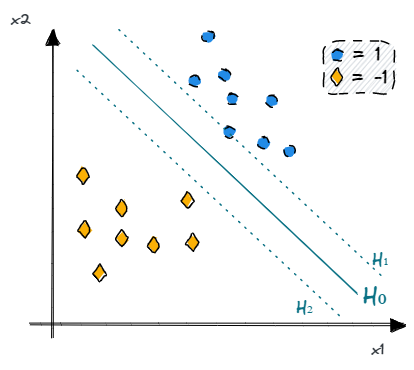


The hyperplanes (H₁, H₂) can therefore be defined as:

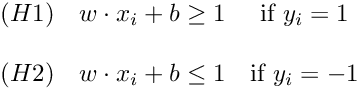

which we can combine into a single equation for a separating hyperplane:

image.png

# **Finding the optimal separating hyperplane**

Since our dataset can be perfectly separated using a hyperplane and any hyperplane can be shifted and rotated by a tiny nudge, we are therefore provided with an infinite amount of possible solutions to choose from.

Thus, we need a reasonable way to decide which of the possible hyperplanes to use.

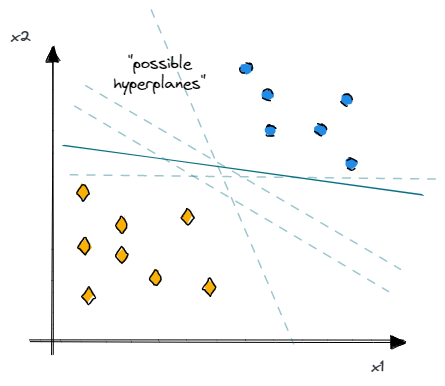

Loosely speaking, the optimal separating hyperplane is the solution that is farthest away from the closest data point — or in other terms which maximizes the margin.

We can also visualize this as two other hyperplanes (support vectors) with a maximized distance in between. The optimal separating hyperplane can then be imagined as a parallel line cutting the margin in two halves.

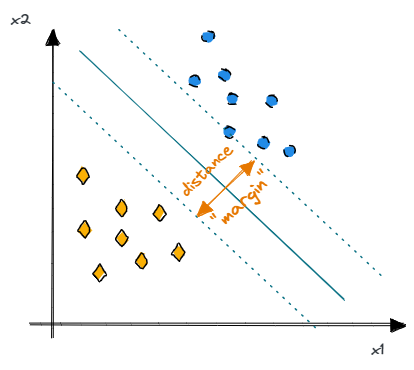

The margin can also be interpreted as a vector that is perpendicular to any hyperplane with a magnitude that is equal to the margin. Thus, we only need to define that vector and solve for the magnitude.

Since our weight vector w is already perpendicular to the hyperplane we can calculate a unit vector u with the same direction as w with the following equation:

image.png

Now, we simply need to scale the unit vector u by a scalar m to obtain a vector k with the same direction and magnitude as the margin.

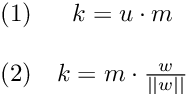

Let’s imagine an arbitrary point x₀ and add our vector k to it, obtaining z₀ = x₀ + k.

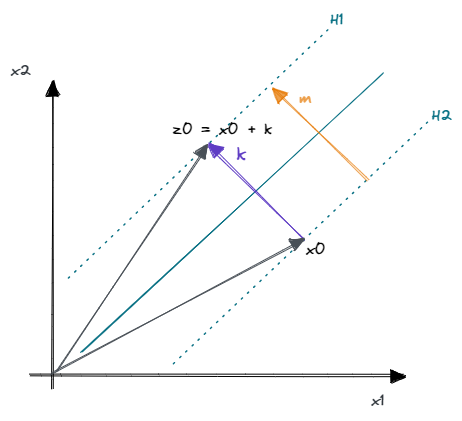

Since z₀ and x₀ lie on the hyperplane H₁ and H₂ respectively, we can solve for the margin like the following:

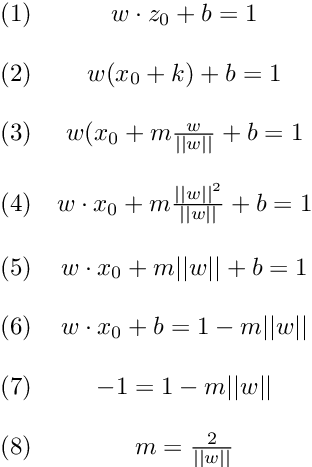


By taking a closer look at our final equation (8), we can see that in order to maximize the margin we simply have to minimize the denominator — the norm of vector w.

This is it, we finally gathered all the ingredients necessary to compute the optimal separating hyperplane. The only thing left to do is to combine all ingredients into a single objective function.

# **The main objective function**

Equipped with the knowledge of how a separating hyperplane is defined and how to compute the distance between two hyperplanes, we can derive the main objective function.

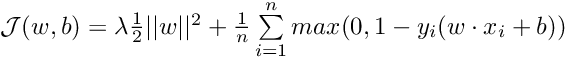

The first term is basically responsible for maximizing the margin, expressed as a minimization problem with an added regularization parameter λ.

The second term — containing our definition of a separating hyperplane — is a loss function called the Hinge loss. Loosely speaking, this term is responsible for ensuring that we predict the correct class label with enough margin.

For example, if yᵢ = 1 and xᵢ is correctly classified, calculating the hinge loss will result in zero since max(0, 1–1) = 0. However, if the class label is falsely predicted the hinge loss will result in a value greater than zero.

Since we are going to optimize the loss function with gradient descent, we need to compute the partial derivatives of the function with respect to the weights and biases. Once we obtain the gradients, we can simply take small steps in the opposite direction in order to minimize the loss.



As you might have noticed that the intercept term b is missing. That’s because we have pushed it into the weight vector like this:

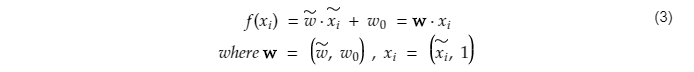

That’s why we added an extra column with all 1s before splitting our dataset.

In [57]:
# >> MODEL TRAINING << #
def compute_cost(W, X, Y):
    # calculate hinge loss
    N = X.shape[0]
    distances = 1 - Y * (np.dot(X, W))
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge_loss = regularization_strength * (np.sum(distances) / N)

    # calculate cost
    cost = 1 / 2 * np.dot(W, W) + hinge_loss
    return cost

# **The Gradient of the Cost Function**

To obtain the (sub-) gradients, we have to distinguish the objective function between two cases:

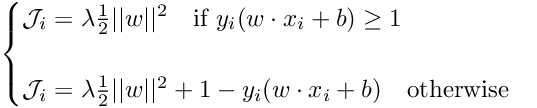

Taking the partial derivatives for the first case gives us the following gradients:

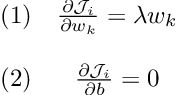

Repeating the same steps for the second case yields:


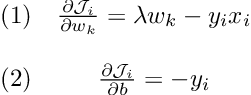


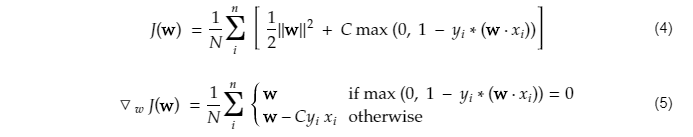

In [58]:
def calculate_cost_gradient(W, X_batch, Y_batch):
    # if only one example is passed (eg. in case of SGD)
    if type(Y_batch) == np.float64:
        Y_batch = np.array([Y_batch])
        X_batch = np.array([X_batch])  # gives multidimensional array

    distance = 1 - (Y_batch * np.dot(X_batch, W))
    dw = np.zeros(len(W))

    for ind, d in enumerate(distance):
        if max(0, d) == 0:
            di = W
        else:
            di = W - (regularization_strength * Y_batch[ind] * X_batch[ind])
        dw += di

    dw = dw/len(Y_batch)  # average
    return dw

## **Implement Gradient Descent**

In [59]:
def sgd(features, outputs):
    max_epochs = 5000
    weights = np.zeros(features.shape[1])
    nth = 0
    prev_cost = float("inf")
    cost_threshold = 0.01  # in percent
    # stochastic gradient descent
    for epoch in range(1, max_epochs):
        # shuffle to prevent repeating update cycles
        X, Y = shuffle(features, outputs)
        for ind, x in enumerate(X):
            ascent = calculate_cost_gradient(weights, x, Y[ind])
            weights = weights - (learning_rate * ascent)

        # convergence check on 2^nth epoch
        if epoch == 2 ** nth or epoch == max_epochs - 1:
            cost = compute_cost(weights, features, outputs)
            print("Epoch is: {} and Cost is: {}".format(epoch, cost))
            # stoppage criterion
            if abs(prev_cost - cost) < cost_threshold * prev_cost:
                return weights
            prev_cost = cost
            nth += 1
    return weights

In [60]:
# >> FEATURE SELECTION << #
def remove_correlated_features(X):
    corr_threshold = 0.9
    corr = X.corr()
    drop_columns = np.full(corr.shape[0], False, dtype=bool)
    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= corr_threshold:
                drop_columns[j] = True
    columns_dropped = X.columns[drop_columns]
    X.drop(columns_dropped, axis=1, inplace=True)
    return columns_dropped

In [61]:
def remove_less_significant_features(X, Y):
    sl = 0.05
    regression_ols = None
    columns_dropped = np.array([])
    for itr in range(0, len(X.columns)):
        regression_ols = sm.OLS(Y, X).fit()
        max_col = regression_ols.pvalues.idxmax()
        max_val = regression_ols.pvalues.max()
        if max_val > sl:
            X.drop(max_col, axis='columns', inplace=True)
            columns_dropped = np.append(columns_dropped, [max_col])
        else:
            break
    regression_ols.summary()
    return columns_dropped

In [62]:
def init():
    print("reading dataset...")
    # read data in pandas (pd) data frame
    data = pd.read_csv('https://raw.githubusercontent.com/virajkapurkar/Machine-Learning/main/data/Breast_Cancer_data.csv')

    # drop last column (extra column added by pd)
    # and unnecessary first column (id)
    data.drop(data.columns[[-1, 0]], axis=1, inplace=True)

    print("applying feature engineering...")
    # convert categorical labels to numbers
    diag_map = {'M': 1.0, 'B': -1.0}
    data['diagnosis'] = data['diagnosis'].map(diag_map)

    # put features & outputs in different data frames
    Y = data.loc[:, 'diagnosis']
    X = data.iloc[:, 1:]

    # filter features
    remove_correlated_features(X)
    remove_less_significant_features(X, Y)

    # normalize data for better convergence and to prevent overflow
    X_normalized = MinMaxScaler().fit_transform(X.values)
    X = pd.DataFrame(X_normalized)

    # insert 1 in every row for intercept b
    X.insert(loc=len(X.columns), column='intercept', value=1)

    # split data into train and test set
    print("splitting dataset into train and test sets...")
    X_train, X_test, y_train, y_test = tts(X, Y, test_size=0.2, random_state=42)

    # train the model
    print("training started...")
    W = sgd(X_train.to_numpy(), y_train.to_numpy())
    print("training finished.")
    print("weights are: {}".format(W))

    # testing the model
    print("testing the model...")
    y_train_predicted = np.array([])
    for i in range(X_train.shape[0]):
        yp = np.sign(np.dot(X_train.to_numpy()[i], W))
        y_train_predicted = np.append(y_train_predicted, yp)

    y_test_predicted = np.array([])
    for i in range(X_test.shape[0]):
        yp = np.sign(np.dot(X_test.to_numpy()[i], W))
        y_test_predicted = np.append(y_test_predicted, yp)

    print("accuracy on test dataset: {}".format(accuracy_score(y_test, y_test_predicted)))
    print("recall on test dataset: {}".format(recall_score(y_test, y_test_predicted)))
    print("precision on test dataset: {}".format(recall_score(y_test, y_test_predicted)))

In [55]:
regularization_strength = 10000
learning_rate = 0.000001

In [63]:
init()

reading dataset...
applying feature engineering...
splitting dataset into train and test sets...
training started...
Epoch is: 1 and Cost is: 7314.374736475841
Epoch is: 2 and Cost is: 6566.178819725784
Epoch is: 4 and Cost is: 5424.043567489462
Epoch is: 8 and Cost is: 3833.7734114552354
Epoch is: 16 and Cost is: 2662.2836287746404
Epoch is: 32 and Cost is: 1970.852620788916
Epoch is: 64 and Cost is: 1612.2224359331565
Epoch is: 128 and Cost is: 1327.2555828959958
Epoch is: 256 and Cost is: 1160.459173313427
Epoch is: 512 and Cost is: 1076.6076610971909
Epoch is: 1024 and Cost is: 1046.4898781249576
Epoch is: 2048 and Cost is: 1040.2415281514252
training finished.
weights are: [ 3.53867376 11.06225569 -2.28619569 -7.8998866  10.15895644 -1.29220637
 -6.45123965  2.24614904 -3.88930791  3.22221445  4.95633449  4.82521551
 -4.73122483]
testing the model...
accuracy on test dataset: 0.9912280701754386
recall on test dataset: 0.9767441860465116
precision on test dataset: 0.976744186046511